# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [1]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [2]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [3]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [4]:
# Remove missing value
df = df[df["CustomerID"].notna()]

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Then we could do some descriptive statistic.

In [5]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [6]:
# Check anomaly data
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


Then just remove those anomaly data

In [7]:
# Remove anomaly
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


The data contains 406829 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [9]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
Country          37
dtype: int64

There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

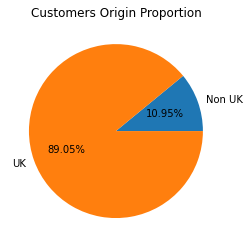

In [10]:
# Simplify country origin
df['Country_isUK'] = np.where(df['Country'] == 'United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

_ = plt.title('Customers Origin Proportion')
_ = plt.pie(customers_origin, labels = customers_origin.index, autopct = lambda p: f'{p:.2f}%')
plt.show()

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [11]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

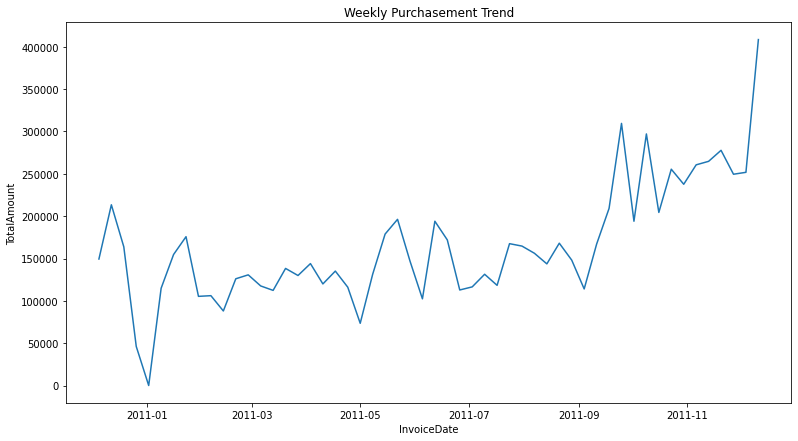

In [12]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Weekly Purchasement Trend')
_ = sns.lineplot(x = weekly_purchasements.index, y = weekly_purchasements)
plt.show()

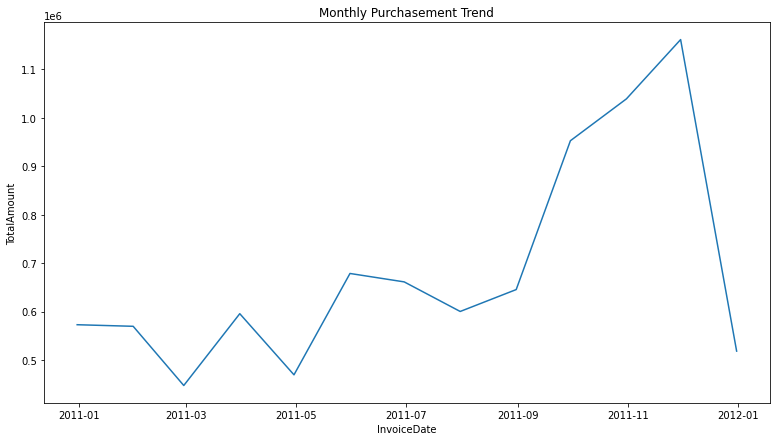

In [13]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Monthly Purchasement Trend')
_ = sns.lineplot(x = monthly_purchasements.index, y = monthly_purchasements)
plt.show()

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [14]:
# Get customer's recency
recency = df.groupby(['CustomerID'])['InvoiceDate'].max()
recency = max(recency) - recency
recency = recency.dt.days
recency = recency.rename('Recency')

recency.head()

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

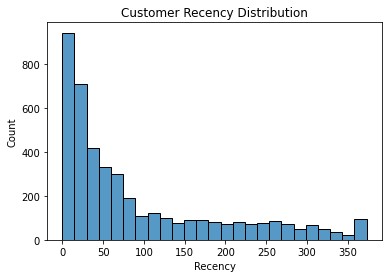

In [15]:
# Recency histogram plot
_ = plt.title('Customer Recency Distribution')
_ = sns.histplot(recency)
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [16]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()
frequency = frequency.rename('Frequency')

frequency.head()

CustomerID
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: Frequency, dtype: int64

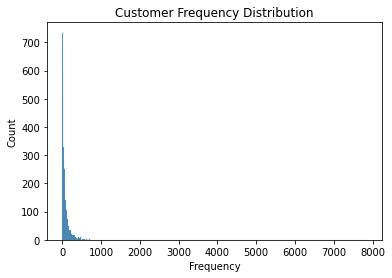

In [17]:
# Frequency histogram plot
_ = plt.title('Customer Frequency Distribution')
_ = sns.histplot(frequency)
plt.show()

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [18]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary')

monetary.head()

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Monetary, dtype: float64

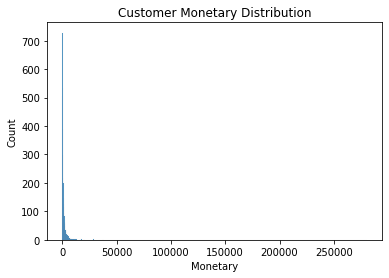

In [19]:
# Monetary histogram plot
_ = plt.title('Customer Monetary Distribution')
_ = sns.histplot(monetary)
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [20]:
# Get customer's country of origin
country = df.groupby(['CustomerID', 'Country_isUK']).size().reset_index().drop(0, axis = 1)

# Merge the data
df_new = country \
    .merge(recency, on = 'CustomerID') \
    .merge(frequency, on = 'CustomerID') \
    .merge(monetary, on = 'CustomerID')

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')

df_new.head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [21]:
# Recode the non numeric variable

df_new = pd.get_dummies(df_new, columns=['Country_isUK'], drop_first=True)
df_new = df_new.rename(columns = {'Country_isUK_UK': 'Country_UK'})

df_new.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0


### Scaling

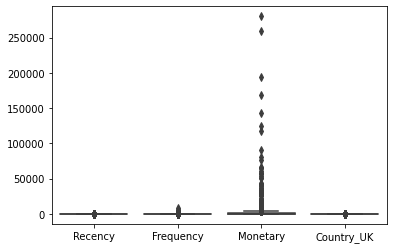

In [22]:
_ = sns.boxplot(data = df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [23]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(df_scaled, columns = df_new.columns, index = df_new.index)

df_scaled.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


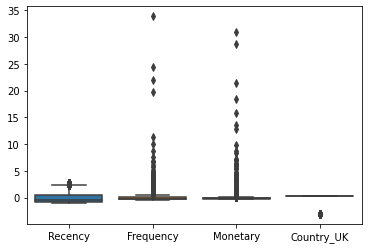

In [24]:
# Plot scaled data
_ = sns.boxplot(data = df_scaled)
plt.show()

## Modeling

In [25]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters = k, random_state = 123).fit(df_scaled)
    
    silhouette.append(silhouette_score(X = df_scaled, labels = kmeans.labels_))

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

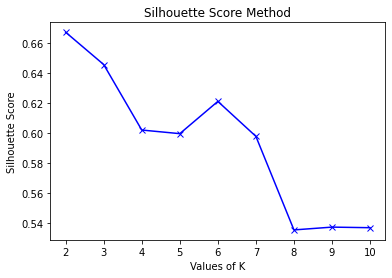

In [26]:
# Plot the score
plt.plot(possible_k, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

Using silhouette score, the best K is either 2 or 6

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


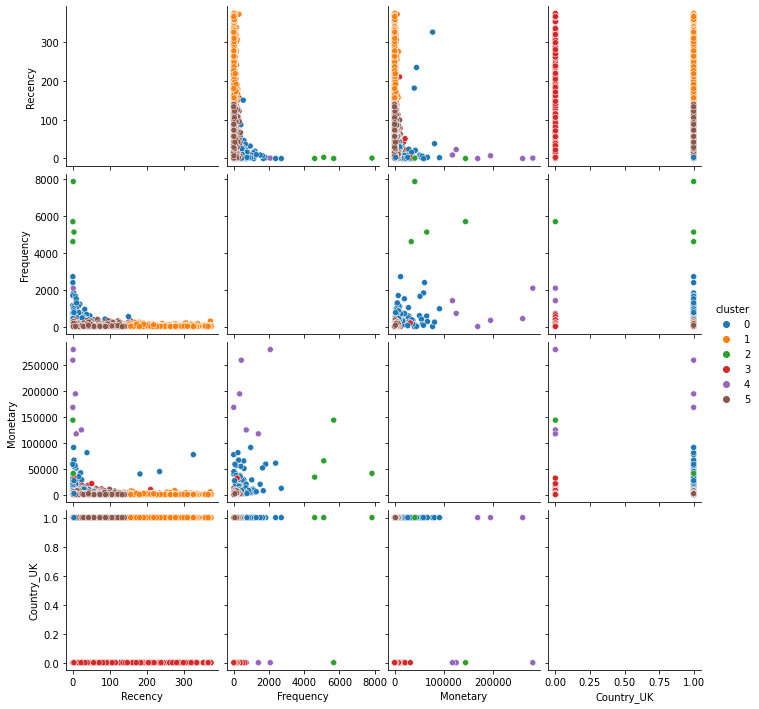

In [27]:
kmeans = KMeans(n_clusters = 6, random_state = 123).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

_ = sns.pairplot(data = df_result_kmeans, hue = 'cluster', diag_kind = 'None', palette = 'tab10')
plt.show()

In [28]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
df_result_kmeans \
    .drop("Country_UK", axis = 1) \
    .groupby('cluster') \
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max']) \
    .transpose()

cluster                      0            1              2             3  \
Recency   mean       15.234973   246.776618       1.000000     95.405797   
          std        35.305176    65.636727       1.414214    104.638705   
          min         0.000000   143.000000       0.000000      0.000000   
          q25         2.000000   189.000000       0.000000     18.000000   
          median      6.000000   242.000000       0.500000     52.000000   
          q75        16.000000   296.000000       1.500000    136.500000   
          max       325.000000   373.000000       3.000000    373.000000   
Frequency mean      535.360656    27.689979    5807.000000     81.396135   
          std       358.078267    32.176026    1429.730044     96.304061   
          min         1.000000     1.000000    4595.000000      1.000000   
          q25       367.000000     8.250000    4982.000000     21.250000   
          median    450.000000    18.000000    5393.000000     45.000000   
          q75       589.500000    33.000000    6218.000000    101.000000   
          max      2700.000000   297.000000    7847.000000    638.000000   
Monetary  mean    13085.065738   450.793070   70925.287500   2262.538913   
          std     16313.461152   610.367153   50424.336433   3479.689136   
          min      1093.650000     3.750000   33719.730000     51.560000   
          q25      4014.945000   163.225000   39173.610000    459.650000   
          median   6923.130000   305.515000   53078.180000   1025.700000   
          q75     13213.210000   505.542500   84829.857500   2659.962500   
          max     91062.380000  7832.470000  143825.060000  31906.820000   

cluster                       4             5  
Recency   mean         6.666667     42.676884  
          std          8.869423     36.313016  
          min          0.000000      0.000000  
          q25          0.250000     14.000000  
          median       4.000000     31.000000  
          q75          8.500000     64.000000  
          max         23.000000    155.000000  
Frequency mean       826.833333     76.270826  
          std        771.620481     74.030983  
          min          3.000000      1.000000  
          q25        360.500000     22.000000  
          median     572.500000     51.000000  
          q75       1228.500000    107.000000  
          max       2076.000000    385.000000  
Monetary  mean    190863.461667   1341.293935  
          std      67791.993010   1592.871914  
          min     117379.630000      6.200000  
          q25     135804.022500    371.700000  
          median  181511.645000    795.120000  
          q75     243380.672500   1720.300000  
          max     280206.020000  17654.540000

In [29]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        1              183
1        1              958
2        0                1
         1                3
3        0              414
4        0                3
         1                3
5        1             2773
Name: Recency, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?
3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

## Question 1

In [30]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


In [36]:
df \
  .groupby('CustomerID') \
  .agg({'TotalAmount':'sum'}) \
  .sort_values(by = 'TotalAmount', ascending = False) \
  .reset_index() \
  .head()

,CustomerID,TotalAmount
0,14646.0,280206.02
1,18102.0,259657.30
2,17450.0,194550.79
3,16446.0,168472.50
4,14911.0,143825.06


Top 5 customer pembelian terbanyak

In [37]:
df_result_kmeans_sorted = df_result_kmeans \
                             .drop("Country_UK", axis = 1) \
                             .groupby(['cluster','CustomerID']) \
                             .agg({'Monetary':'sum'}) \
                             .reset_index() 

In [38]:
df_result_kmeans_sorted \
      .groupby('cluster') \
      .apply(lambda x: x.sort_values(by='Monetary', ascending=False).head(5))\
      .drop("cluster", axis = 1)

CustomerID   Monetary
cluster                            
0       158      17511.0   91062.38
        107      16029.0   81024.84
        0        12346.0   77183.60
        119      16684.0   66653.56
        27       13694.0   65039.62
1       232      13093.0    7832.47
        212      12980.0    7374.90
        838      16553.0    5719.82
        1043     17850.0    5391.21
        553      15032.0    4959.10
2       1143     14911.0  143825.06
        1142     14096.0   65164.79
        1144     17841.0   40991.57
        1141     12748.0   33719.73
3       1552     17404.0   31906.82
        1470     12753.0   21429.39
        1467     12744.0   21279.29
        1243     12471.0   19824.05
        1457     12731.0   18895.91
4       1561     14646.0  280206.02
        1564     18102.0  259657.30
        1563     17450.0  194550.79
        1562     16446.0  168472.50
        1559     12415.0  124914.53
5       1603     12901.0   17654.54
        2468     14607.0   16569.50
        2599     14866.0   14389.90
        3450     16525.0   13027.45
        2295     14258.0   12669.98

top 5 customer with highest Total Amount based on cluster

In [39]:
df \
   .groupby('InvoiceDate') \
   .agg({'InvoiceNo':'count'}) \
   .sort_values(by = 'InvoiceNo', ascending = False) \
   .reset_index().head()

,InvoiceDate,InvoiceNo
0,2011-11-14 15:27:00,542
1,2011-11-28 15:54:00,533
2,2011-12-05 17:17:00,529
3,2011-11-23 13:39:00,443
4,2011-10-31 14:09:00,435


the time of purchase with the highest number of customers is 2011-11-14 at 15:27:00

## Question 2

1. As we see that there are customer outside UK for **cluster 2, 3, and 4**. To stole their attention. Here are some promotion recommendation:

- Free shipping: Offer discounted shipping for international customers to make customer more interesting to purchase more product 
- Multi-currency pricing: Display product price base on customer's country. It make them easier to recognize the prize and compare it
- discount codes: Offer discount codes for certain event like christmas sale, etc.
- Free gifts: Offer a free little gift every purchase like stickers, etc.
- Extended return policy: Offer an extended guarantee time for product

2. For customer that have high frequency in **cluster 0 and 2** (often purchase products) here are some promotion recommendation:

- Free gifts with minimum purchase: Offer a free gift a minimum purchase amount.
- Buy two get three promotions: Offer a free product or a discount after two purchase. "Buy two get three" means if customer buy 2 they'll get a free product so 2 + 1 = 3 and customer get three products
- Member Loyalty rewards: Offer a member loyalty program that rewards customers for frequent purchases or for reaching certain order thresholds
- Limited-time promotions: Offer limited-time promotions to make them always purchase product

3. For customer with highest purchase like in **cluster 2 and 4**
- Tiered discounts: Offer increasing discounts as customers add more items to their cart, such as 10% off orders over USD 50 or 20% off orders over USD 100.
- Free shipping on larger orders: Offer free shipping for orders over a certain amount to encourage customers to add more items to their cart.
- Exclusive member: Offer exclusive member or VIP member to customers who have made the highest purchase so they can get exclusive discount or personalized recommendation
- Early access to sales: Offer early access to sales or new products to your top customers as a way to show your appreciation and incentivize them to make additional purchases.

4. For customer that rarely shop **(cluster 1)**. Here are some recommendation
- Welcome discounts: Offer a welcome discount or coupon to new customers who sign up for the first time using email.
- Free trial or sample: Offer a free trial or sample of your product or service to new customers to allowing them to try it before purchase.
- Referral discounts: Offer a discount to new customers who are referred by existing customers, incentivizing them to make a first purchase and potentially become repeat customers themselves.

## Question 3

In [46]:
df_nonUK = df[df['Country_isUK'] != 'UK']
df_nonUK.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France,Non UK,90.0
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France,Non UK,90.0
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France,Non UK,45.0
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France,Non UK,10.2
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France,Non UK,15.6


In [41]:
df_nonUK.isna().sum()

InvoiceNo       0
StockCode       0
Description     0
Quantity        0
InvoiceDate     0
UnitPrice       0
CustomerID      0
Country         0
Country_isUK    0
TotalAmount     0
dtype: int64

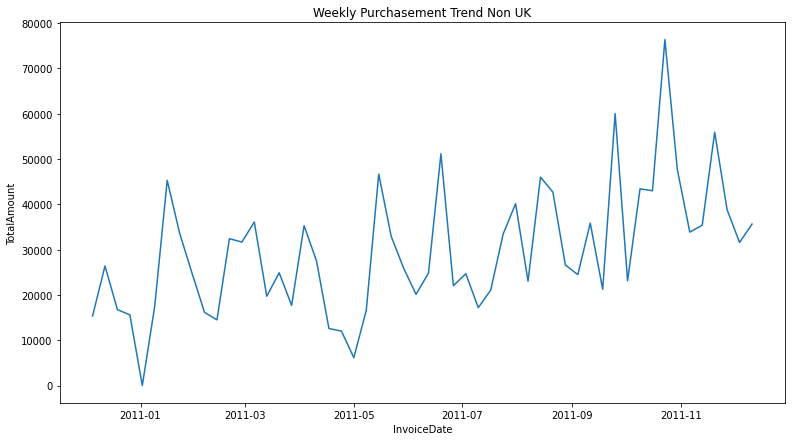

In [42]:
# Plot weekly trend
weekly_purchasements_nonUK = df_nonUK.copy()
weekly_purchasements_nonUK = weekly_purchasements_nonUK.groupby(by = pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Weekly Purchasement Trend Non UK')
_ = sns.lineplot(x = weekly_purchasements_nonUK.index, y = weekly_purchasements_nonUK)
plt.show()

Based on the picture above, it can be seen that there was an increase in total purchases at the end of week.

For non UK customer we can see that it has highest purchasement around 700000 pound or more

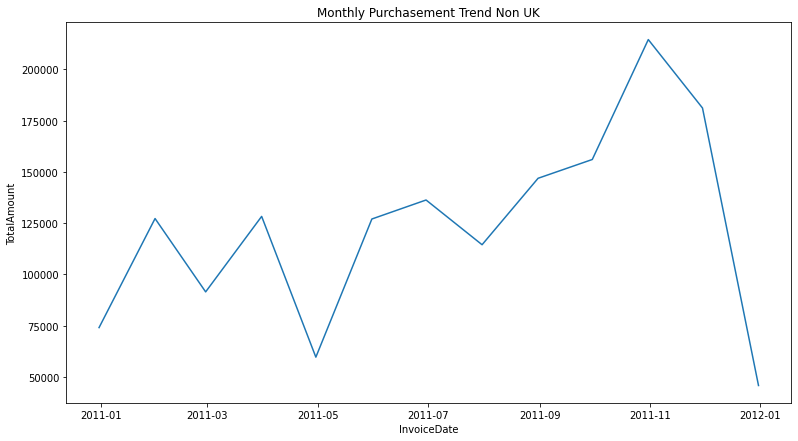

In [43]:
# Plot weekly trend
monthly_purchasements_nonUK = df_nonUK.copy()
monthly_purchasements_nonUK = monthly_purchasements_nonUK.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Monthly Purchasement Trend Non UK')
_ = sns.lineplot(x = monthly_purchasements_nonUK.index, y = monthly_purchasements_nonUK)
plt.show()

Based on the picture above, it can be seen that there was an increase in total purchases at the end of year.

## Recency

In [44]:
# Get customer's recency
recency_nonUK = df_nonUK.groupby(['CustomerID'])['InvoiceDate'].max()
recency_nonUK = max(recency_nonUK) - recency_nonUK
recency_nonUK = recency_nonUK.dt.days
recency_nonUK = recency_nonUK.rename('Recency')

recency_nonUK.head()

CustomerID
12347.0      1
12348.0     74
12349.0     18
12350.0    309
12352.0     35
Name: Recency, dtype: int64

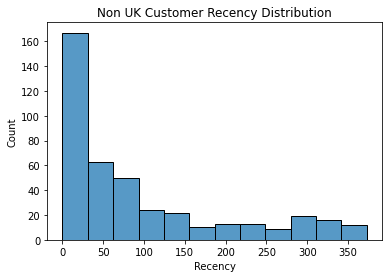

In [45]:
# Recency histogram plot
_ = plt.title('Non UK Customer Recency Distribution')
_ = sns.histplot(recency_nonUK)
plt.show()

## Frequency

In [47]:
# Count frequency
frequency_nonUK = df_nonUK.groupby(['CustomerID'])['InvoiceNo'].count()
frequency_nonUK = frequency_nonUK.rename('Frequency')

frequency_nonUK.head()

CustomerID
12347.0    182
12348.0     31
12349.0     73
12350.0     17
12352.0     85
Name: Frequency, dtype: int64

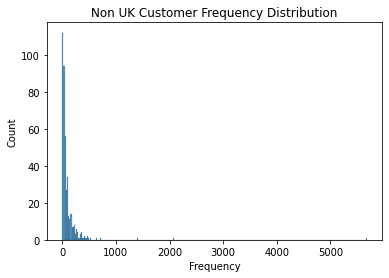

In [48]:
# Frequency histogram plot
_ = plt.title('Non UK Customer Frequency Distribution')
_ = sns.histplot(frequency_nonUK)
plt.show()

## Monetary

In [49]:
# Sum the money spent
monetary_nonUK = df_nonUK.groupby(['CustomerID'])['TotalAmount'].sum()
monetary_nonUK = monetary_nonUK.rename('Monetary')

monetary_nonUK.head()

CustomerID
12347.0    4310.00
12348.0    1797.24
12349.0    1757.55
12350.0     334.40
12352.0    2506.04
Name: Monetary, dtype: float64

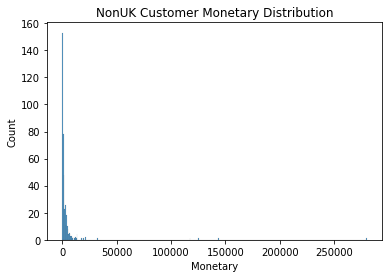

In [50]:
# Monetary histogram plot
_ = plt.title('NonUK Customer Monetary Distribution')
_ = sns.histplot(monetary_nonUK)
plt.show()

## Merge RFM Data

In [51]:
# Get customer's country of origin
country_nonUK = df_nonUK.groupby('CustomerID').size().reset_index().drop(0, axis = 1)

# Merge the data
df_nonUK_new = country_nonUK \
    .merge(recency_nonUK, on = 'CustomerID') \
    .merge(frequency_nonUK, on = 'CustomerID') \
    .merge(monetary_nonUK, on = 'CustomerID')

# Set CustomerID as index
df_nonUK_new = df_nonUK_new.set_index('CustomerID')

df_nonUK_new.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40
12352.0,35,85,2506.04


We are not doing one hot encoding for the data because we are just focus in non UK country which is one kind category. We just need to drop the field

## Scaling

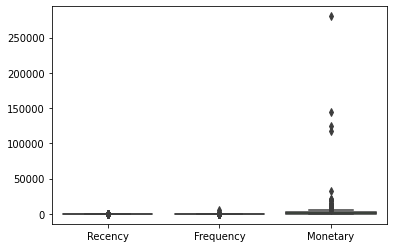

In [52]:
_ = sns.boxplot(data = df_nonUK_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [53]:
# Scale the data

scaler = StandardScaler()
df_nonUK_scaled = scaler.fit_transform(df_nonUK_new)

df_nonUK_scaled = pd.DataFrame(df_nonUK_scaled, columns = df_nonUK_new.columns, index = df_nonUK_new.index)

df_nonUK_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,-0.896621,0.248302,0.026983
12348.0,-0.197122,-0.233730,-0.115746
12349.0,-0.733724,-0.099655,-0.118001
12350.0,2.054690,-0.278422,-0.198838
12352.0,-0.570827,-0.061348,-0.075485


## Modeling

In [54]:
# Modeling
possible_k_nonUK = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_nonUK = []

for k in possible_k:
    kmeans = KMeans(n_clusters = k, random_state = 123).fit(df_nonUK_scaled)
    
    silhouette_nonUK.append(silhouette_score(X = df_nonUK_scaled, labels = kmeans.labels_))

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

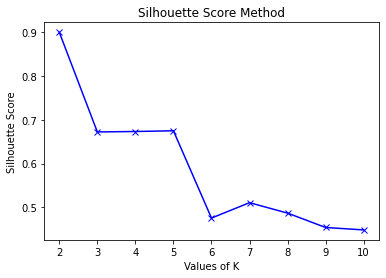

In [55]:
# Plot the score
plt.plot(possible_k_nonUK, silhouette_nonUK, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

Using silhouette score, the best K is either 2 or 7

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


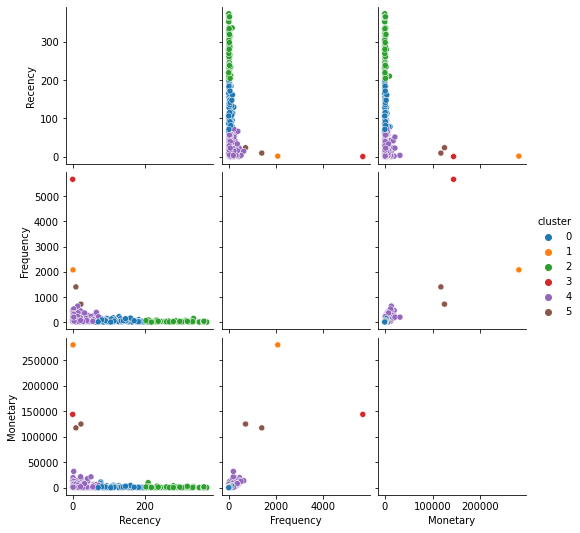

In [56]:
kmeans = KMeans(n_clusters = 6, random_state = 123).fit(df_nonUK_scaled)

df_nonUK_result_kmeans = df_nonUK_new.copy()
df_nonUK_result_kmeans['cluster'] = kmeans.labels_

_ = sns.pairplot(data = df_nonUK_result_kmeans, hue = 'cluster', diag_kind = 'None', palette = 'tab10')
plt.show()

- have a high score in recency, it means that that they were make a purchasement for a long time ago. Have a low score in frequency, it means that they rarely make a purchasement. Have a low score in monetary, it means that they have a little size of purchasement **(cluster 0 and cluster 2)**

- have a low score in recency, it means that that they recently make a purchasements. Have a high score in frequency, it means that they often make a purchasement. Have a high score in monetary, it means that they have a huge size of purchasement **(cluster 1 and cluster 3)**

- **Cluster 4:** have a low score in recency, it means that that they recently make a purchasements. Have a mid score in frequency, it means that they tend to make frequent purchasements. Have a high score in monetary, it means that they have a huge size of purchasement, **maybe they're a customers who purchase luxury items**

- **Cluster 5:** have a low score in recency, it means that that they recently make a purchasements. Have a high score in frequency, it means that they often make a purchasement. Have a highest score in monetary. **Maybe they're customer which is a distributor**

In [57]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
df_nonUK_result_kmeans \
    .groupby('cluster') \
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max']) \
    .transpose().fillna(0)

cluster                      0          1            2          3  \
Recency   mean      108.684685       1.00   289.285714       0.00   
          std        38.250842       0.00    49.965213       0.00   
          min        58.000000       1.00   203.000000       0.00   
          q25        77.000000       1.00   242.000000       0.00   
          median     99.000000       1.00   290.000000       0.00   
          q75       134.000000       1.00   329.000000       0.00   
          max       197.000000       1.00   373.000000       0.00   
Frequency mean       45.126126    2076.00    24.909091    5675.00   
          std        38.947078       0.00    24.089844       0.00   
          min         2.000000    2076.00     1.000000    5675.00   
          q25        21.000000    2076.00    10.000000    5675.00   
          median     34.000000    2076.00    18.000000    5675.00   
          q75        53.500000    2076.00    28.000000    5675.00   
          max       219.000000    2076.00   149.000000    5675.00   
Monetary  mean     1218.059910  280206.02   816.680000  143825.06   
          std      1500.519510       0.00  1287.578996       0.00   
          min        51.560000  280206.02    63.000000  143825.06   
          q25       439.010000  280206.02   218.450000  143825.06   
          median    803.560000  280206.02   415.700000  143825.06   
          q75      1299.145000  280206.02   889.240000  143825.06   
          max     11072.670000  280206.02  9864.260000  143825.06   

cluster                      4              5  
Recency   mean       22.827434      16.000000  
          std        17.246484       9.899495  
          min         0.000000       9.000000  
          q25         8.000000      12.500000  
          median     21.000000      16.000000  
          q75        33.750000      19.500000  
          max        72.000000      23.000000  
Frequency mean      118.455752    1057.000000  
          std       113.867214     485.075252  
          min         2.000000     714.000000  
          q25        36.000000     885.500000  
          median     83.500000    1057.000000  
          q75       161.000000    1228.500000  
          max       638.000000    1400.000000  
Monetary  mean     3268.150885  121147.080000  
          std      4277.292021    5327.978886  
          min        91.680000  117379.630000  
          q25       723.802500  119263.355000  
          median   1804.930000  121147.080000  
          q75      3981.195000  123030.805000  
          max     31906.820000  124914.530000

In [58]:
df_nonUK_result_kmeans.groupby("cluster")["Recency"].sum()

cluster
0    12064
1        1
2    22275
3        0
4     5159
5       32
Name: Recency, dtype: int64

In [59]:
df_nonUK_result_kmeans.groupby("cluster")["Frequency"].sum()

cluster
0     5009
1     2076
2     1918
3     5675
4    26771
5     2114
Name: Frequency, dtype: int64

In [60]:
df_nonUK_result_kmeans.groupby("cluster")["Monetary"].sum()

cluster
0    135204.65
1    280206.02
2     62884.36
3    143825.06
4    738602.10
5    242294.16
Name: Monetary, dtype: float64